# Import libraries

In [ ]:
import tensorflow as tf 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,  Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input,BatchNormalization, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, History, TensorBoard,ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import time 
import re
import os
from PIL import Image
history = History()
#%matplotlib inline

In [2]:
%pip uninstall keras


In [ ]:
%pip install keras==2.3.1

In [ ]:
%pip install --upgrade tensorflow --user
%pip install --upgrade keras --user


In [2]:
datapath = r"C:\Users\JUANPABLOGASCA\Desktop\Pacientes_CNN\P01\Clases-32"#r"C:\Users\JUANPABLOGASCA\Desktop\ALL-BY-ONE\\32"
imgpath = datapath + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, datapath, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0

dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('Suma Total de imagenes en subdirs:',sum(dircount))


leyendo imagenes de  C:\Users\JUANPABLOGASCA\Desktop\ALL-BY-ONE\\32\
C:\Users\JUANPABLOGASCA\Desktop\ALL-BY-ONE\\32\CLASE_1 1
C:\Users\JUANPABLOGASCA\Desktop\ALL-BY-ONE\\32\CLASE_2 18720
C:\Users\JUANPABLOGASCA\Desktop\ALL-BY-ONE\\32\CLASE_3 18720
C:\Users\JUANPABLOGASCA\Desktop\ALL-BY-ONE\\32\CLASE_4 18720
C:\Users\JUANPABLOGASCA\Desktop\ALL-BY-ONE\\32\CLASE_5 18720
C:\Users\JUANPABLOGASCA\Desktop\ALL-BY-ONE\\32\CLASE_6 18720
Directorios leidos: 6
Imagenes en cada directorio [18721, 18720, 18720, 18720, 18720, 18719]
Suma Total de imagenes en subdirs: 112320


In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

# **DATA PREPARATION**

In [5]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)   
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

Cantidad etiquetas creadas:  112320


In [6]:
posturas=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    posturas.append(name[len(name)-1])
    indice=indice+1

0 CLASE_1
1 CLASE_2
2 CLASE_3
3 CLASE_4
4 CLASE_5
5 CLASE_6


In [7]:
y = np.array(labels)
X = np.array(images) #convierto de lista a numpy

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  6
Output classes :  [0 1 2 3 4 5]


In [8]:
from sklearn.model_selection import train_test_split

# Test data // for testing at the end after tranning 
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
#print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

# validation data // for testing when tranning 

train_X,val_X,train_Y,val_Y = train_test_split(train_X,train_Y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('validation data shape : ', val_X.shape, val_Y.shape)

Testing data shape :  (22464, 32, 32, 4) (22464,)
Training data shape :  (71884, 32, 32, 4) (71884,)
validation data shape :  (17972, 32, 32, 4) (17972,)


# **CNN Training**

In [9]:

img_x = 32
img_y = 32
img_z = 4
num_classes = 6

batch_size = 32
epochs = 100

# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# because the MNIST is greyscale, we only have a single channel - RGB colour images would have 3
input_shape = (img_x, img_y, img_z)

# convert the data to the right type
#train_X = train_X.reshape(train_X.shape[0], img_x, img_y, img_z)
#test_X = test_X.reshape(test_X.shape[0], img_x, img_y, img_z)
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
val_X = val_X.astype('float32')

print('train_X shape:', train_X.shape)
print(train_X.shape[0], 'train samples')
print(val_X.shape[0], 'val samples')
print(test_X.shape[0], 'test samples')

# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below
#train_Y = tf.keras.utils.to_categorical(train_Y, num_classes)
#test_Y = tf.keras.utils.to_categorical(test_Y, num_classes)


# Guardar el modelo con nombre del tiempo en que se entreno para no sobreescribir los modelos

#NAME ="model_all_to_one_32px-{}".format(int(time.time()))

#NAME = 'all_to_on_300seg'

#tensorboard = TensorBoard(log_dir=r'C:\Users\hpalm\Desktop\Programacion\Proyecto_de_grado\Jupyter\Codigo\logs\p10_2')

train_X shape: (71884, 32, 32, 4)
71884 train samples
17972 val samples
22464 test samples


# **hyperparametor tuning**

In [10]:
from kerastuner import RandomSearch 
from kerastuner.engine.hyperparameters import HyperParameters
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
import tensorflow as tf



c:\Users\JUANPABLOGASCA\miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [11]:
custom_early_stopping = EarlyStopping(monitor="loss",patience=3)

In [12]:
def build_model(hp):  

  custom_early_stopping = EarlyStopping(monitor="val_loss",patience=3)
  model = tf.keras.models.Sequential([
    Conv2D(
        filters=hp.Int('conv_1_filter', min_value=16, max_value=64, step=8),
        kernel_size=(3,3),
        strides=(2, 2),
        padding='same',
        activation='relu' 
    ),
    Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)),
    Conv2D(
        filters=hp.Int('conv_2_filter', min_value=16, max_value=64, step=8),
        kernel_size=(3,3),
        strides=(2, 2),
        padding='same',
        activation='relu' 
    ),
    Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)),
    Conv2D(
        filters=hp.Int('conv_3_filter', min_value=16, max_value=64, step=8),
        kernel_size=(3,3),
        strides=(2, 2),
        padding='same',
        activation='relu' 
    ),
    Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)),
    Conv2D(
        filters=hp.Int('conv_4_filter', min_value=16, max_value=64, step=8),
        kernel_size=(3,3),
        strides=(2, 2),
        padding='same',
        activation='relu' 
    ),
    Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)),
    MaxPooling2D(
      pool_size=(2, 2),
      strides=2
    ),
    Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)),
    
    Flatten(),
    Dense(units=hp.Int('dense_units', min_value=32, max_value=256, step=32),
      activation='relu'),
    Dense(6, activation='softmax')
  ])
  

  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  
  return model

In [13]:
tuner_search=RandomSearch(build_model, objective='val_accuracy',max_trials=20,directory=r"C:\Users\JUANPABLOGASCA\Desktop\ALL -TENSORBOARD\modelos",project_name='sEMG Clasification_dau_1')

In [1]:
tuner_search.search(train_X, train_Y,epochs=50,validation_data=(val_X, val_Y),callbacks=[custom_early_stopping])


NameError: name 'tuner_search' is not defined

In [65]:
model = tuner_search.get_best_models(num_models=1)[0]

In [66]:
model.build([9097,32,32,3])

In [67]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (9097, 16, 16, 24)        672       
                                                                 
 dropout (Dropout)           (9097, 16, 16, 24)        0         
                                                                 
 conv2d_1 (Conv2D)           (9097, 8, 8, 56)          12152     
                                                                 
 dropout_1 (Dropout)         (9097, 8, 8, 56)          0         
                                                                 
 conv2d_2 (Conv2D)           (9097, 4, 4, 40)          20200     
                                                                 
 dropout_2 (Dropout)         (9097, 4, 4, 40)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (9097, 2, 2, 40)         0

#  **Showing architecture**

In [68]:
import visualkeras
from PIL import ImageFont
from tensorflow.keras import layers
from collections import defaultdict
from PIL import Image

# Definir la fuente
font = ImageFont.truetype("arial.ttf", 20)

color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = '#00f5d4'
color_map[layers.MaxPooling2D]['fill'] = '#8338ec'
color_map[layers.Dense]['fill'] = '#fb5607'
color_map[layers.Flatten]['fill'] = '#ffbe0b'

img = visualkeras.layered_view(model, legend=True, font=font,color_map=color_map)
#img.save(r"C:\Users\JUANPABLOGASCA\Desktop\Pacientes_CNN\Arquitectura - CNN\CNN.png", "PNG")

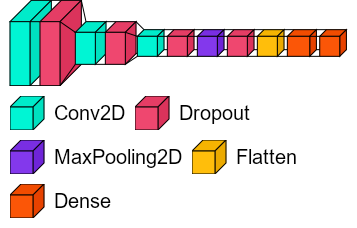

In [69]:
img

In [74]:
def visualizacion_resultados(model):
  
  fig, ax = plt.subplots(1,2)
  acc = model.history['acc']
  loss = model.history['loss']
  val_acc = model.history['val_acc']
  val_loss = model.history['val_loss']
  epochs  = range(len(acc))
  fig.set_size_inches(16,9)

  ax[0].plot(epochs,acc,'go-',label = 'Entrenamiento accuracy')
  ax[0].plot(epochs,val_acc,'ro-',label = 'validacion acurracy')
  ax[0].set_title('Entrenamiento & validacion accuracy')
  ax[0].legend()
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('accuracy')

  ax[1].plot(epochs,loss,'go-',label = 'Entrenamiento Loss')
  ax[1].plot(epochs,val_loss,'ro-',label = 'validacion Loss')
  ax[1].set_title('Entrenamiento & validacion Test')
  ax[1].legend()
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')

  plt.show()

TypeError: 'NoneType' object is not subscriptable

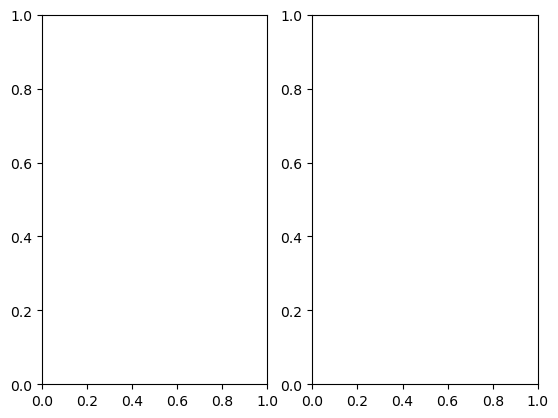

In [75]:
visualizacion_resultados(model)

In [13]:
if os.path.isfile(r"C:\Users\hpalm\Desktop\Programacion\Proyecto_de_grado\Jupyter\Modelos\transfer_learning_P1.h5") is False:
  model.save(r'C:\Users\hpalm\Desktop\Programacion\Proyecto_de_grado\Jupyter\Modelos\transfer_learning_P1.h5')

# **Generate predictions**

In [22]:
predicted_classes2 = model.predict(test_X)

In [23]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [24]:
predicted_classes.shape, test_Y.shape

((1124,), (1124,))

In [25]:
#rounded_labels = np.argmax(test_Y, axis=1)
rounded_labels = test_Y
rounded_labels[5]

5

# **MATRIX CONFUSION**

In [26]:
from sklearn.metrics import confusion_matrix
import itertools


#predicted_classes_m = np.argmax(predicted_classes,axis=1)
#test_Y_m = np.argmax(test_Y,axis=1)
#Esto es dificil de leer 

#confusion_matrix(test_Y, predicted_classes_m)

cm = confusion_matrix(rounded_labels,predicted_classes)



In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],'.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.savefig(r'C:\Users\hpalm\Desktop\Programacion\Proyecto_de_grado\Jupyter\Matrices de confusion\all_to_one_32_18_1_2deci.png', transparent = False, bbox_inches = 'tight')

In [35]:
#function that return  a confusion matrix and plot it 

Normalized confusion matrix
[[0.90909091 0.00478469 0.01435407 0.05263158 0.01913876 0.        ]
 [0.00552486 0.96132597 0.03314917 0.         0.         0.        ]
 [0.01052632 0.06315789 0.91578947 0.         0.01052632 0.        ]
 [0.01183432 0.         0.01183432 0.94674556 0.0295858  0.        ]
 [0.00568182 0.         0.         0.03977273 0.95454545 0.        ]
 [0.         0.         0.         0.         0.         1.        ]]


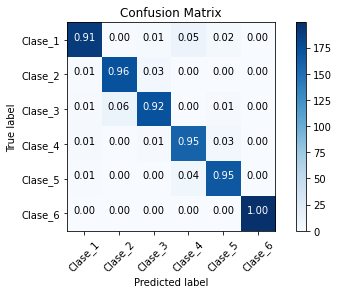

In [28]:
cm_plot_labels = ['Clase_1','Clase_2','Clase_3','Clase_4','Clase_5','Clase_6']
plot_confusion_matrix(cm,cm_plot_labels, title = 'Confusion Matrix')


# **METRICS OF THE CONFUSION MATRIX**

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


poly_accuracy = accuracy_score(rounded_labels, predicted_classes)
poly_f1 = f1_score(rounded_labels, predicted_classes, average='weighted')
poly_recall = recall_score(rounded_labels, predicted_classes, average='macro')
poly_precision = precision_score(rounded_labels, predicted_classes, average='macro')

print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))
print('Recall_Score (Polynomial Kernel): ', "%.2f" % (poly_recall*100))
print('Precision (Polynomial Kernel): ', "%.2f" % (poly_precision*100))

Accuracy (Polynomial Kernel):  94.75
F1 (Polynomial Kernel):  94.75
Recall_Score (Polynomial Kernel):  94.79
Precision (Polynomial Kernel):  94.63
